Epoch 0, Training Loss: 0.5508378148078918, Validation Loss: 0.6925574541091919
Epoch 500, Training Loss: 0.002351694041863084, Validation Loss: 0.0060490807518363
Epoch 1000, Training Loss: 0.000595034274738282, Validation Loss: 0.0016672252677381039
Epoch 1500, Training Loss: 0.00037571421125903726, Validation Loss: 0.0011545082088559866
Epoch 2000, Training Loss: 0.00025702398852445185, Validation Loss: 0.0008080392144620419
Epoch 2500, Training Loss: 0.00015969802916515619, Validation Loss: 0.0005775670288130641


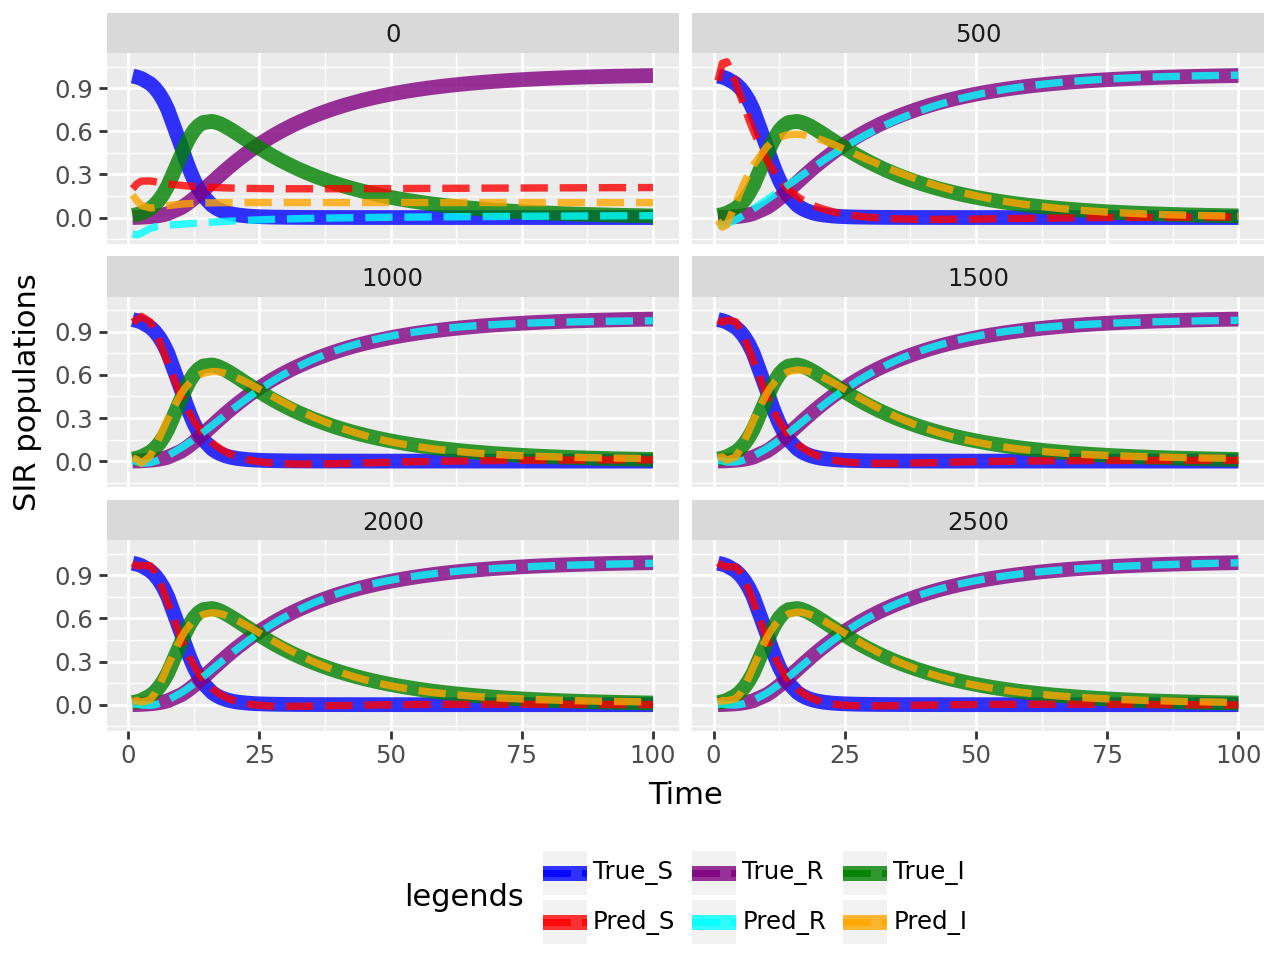

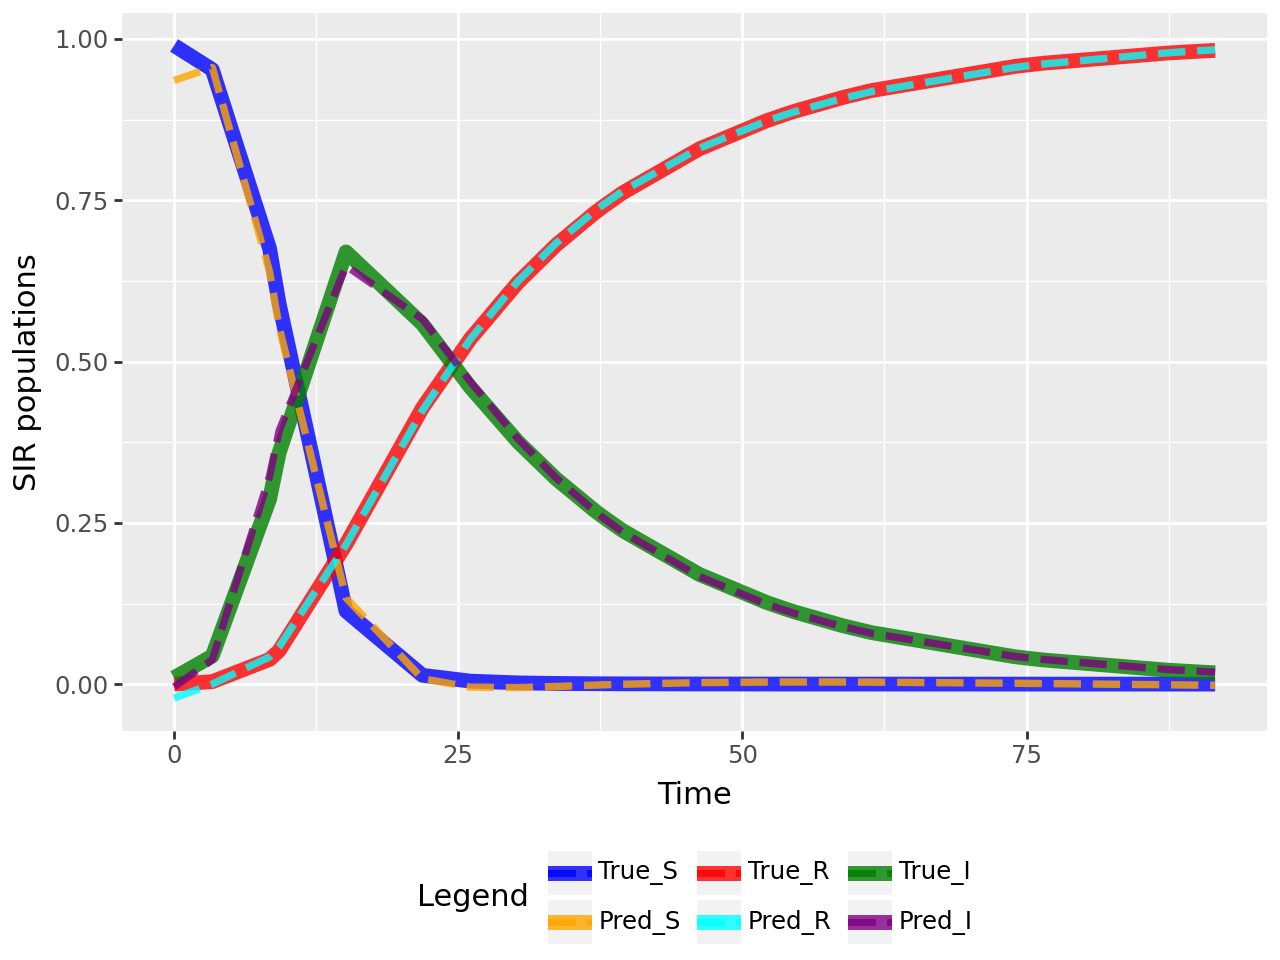

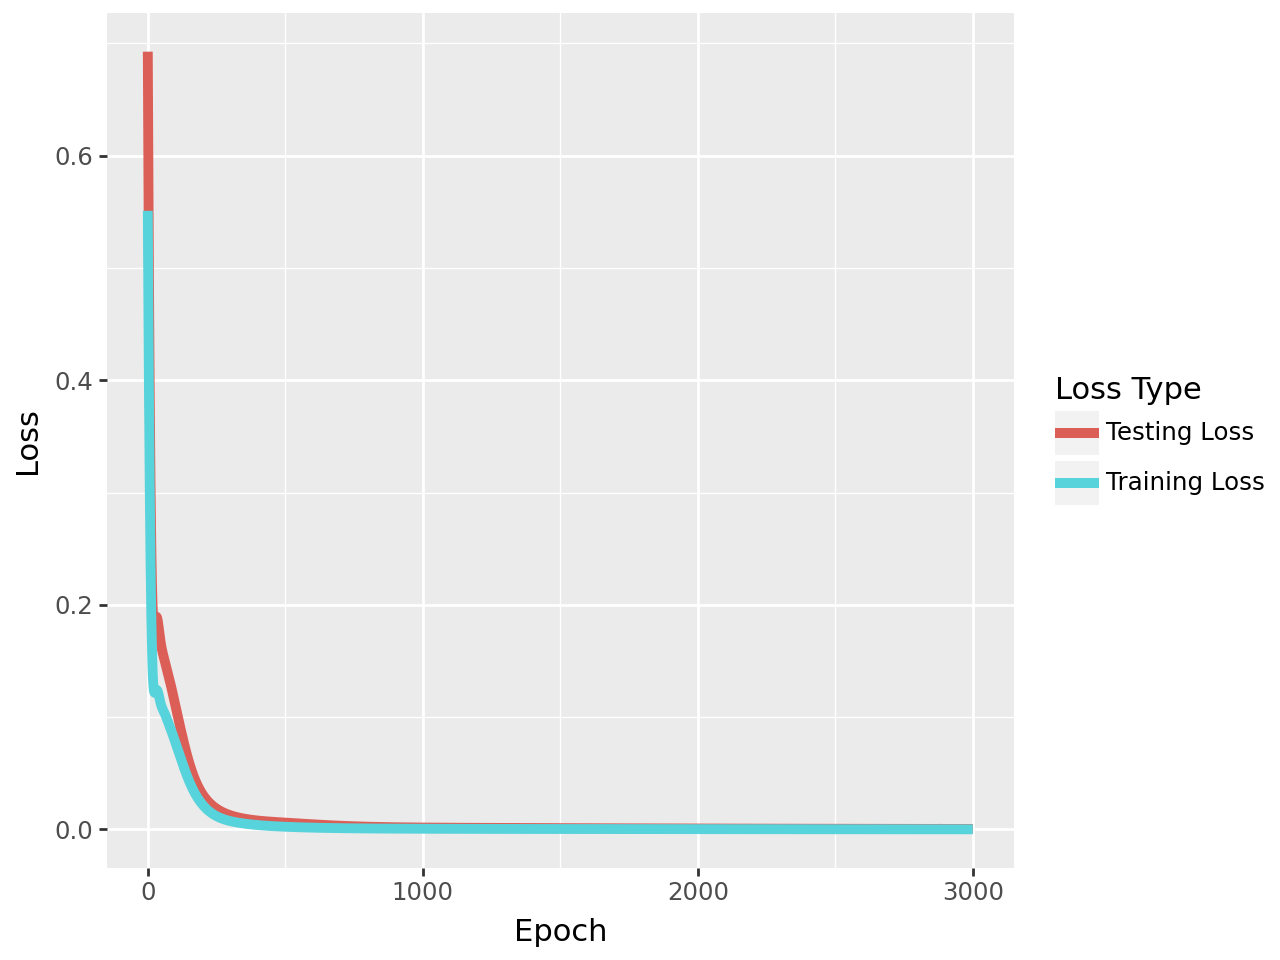

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from data_utils import *
from model import PINN
from training import train_with_physics_loss
from plot_utils import *

import warnings
warnings.filterwarnings("ignore")


def main():
    # Configuration parameters
    beta = 0.5  # Infection rate
    gamma = 0.05  # Recovery rate
    T = 100  # Total time
    num_samples = 120  # Number of samples
    S0 = 0.99  # Initial susceptible population
    I0 = 0.01  # Initial infected population
    R0 = 0.0  # Initial recovered population
    test_size = 0.2
    random_state = 42
    input_dim = 1
    hidden_dims = [100,100,100]
    output_dim = 3
    activation_functions = [nn.Sigmoid, nn.Tanh, nn.ReLU, nn.LeakyReLU, nn.ELU, nn.SELU, nn.Softmax, nn.LogSoftmax, nn.GELU ]

    activation_fn = activation_functions[1]
    batch_size = 32
    learning_rate = 1e-4
    epochs = 3000
    patience = 1000
    EPOCH_INTERVAL = 500


    # Simulate data
    t, S_data, I_data, R_data = simulate_data(beta, gamma, T, num_samples, S0, I0, R0)

    # Split data into training and validation sets and Load and prepare data 
    t_train_set, t_test_set, data_S_train_set, data_I_train_set, data_R_train_set, data_S_test_set, data_I_test_set, data_R_test_set = load_and_prepare_data(test_size, random_state)

    # Initialize the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize the model, optimizer, and loss function
    model = PINN(input_dim, hidden_dims, output_dim, activation_fn).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Convert data to tensors and prepare DataLoader
    train_loader = prepare_dataloader(t_train_set, data_S_train_set, data_I_train_set, data_R_train_set, batch_size, device)
    t_train_tensor = to_tensor(t_train_set, device, requires_grad=True)
    data_S_train_tensor = to_tensor(data_S_train_set, device)
    data_I_train_tensor = to_tensor(data_I_train_set, device)
    data_R_train_tensor = to_tensor(data_R_train_set, device)
    t_val_tensor = to_tensor(t_test_set, device, requires_grad=False)
    data_S_val_tensor = to_tensor(data_S_test_set, device)
    data_I_val_tensor = to_tensor(data_I_test_set, device)
    data_R_val_tensor = to_tensor(data_R_test_set, device)

    # Train the model with physics loss
    train_losses, val_losses, history = train_with_physics_loss(model, optimizer, epochs, patience, t_train_tensor, data_S_train_tensor, data_I_train_tensor, data_R_train_tensor, 
                                                                t_val_tensor, data_S_val_tensor, data_I_val_tensor, data_R_val_tensor, beta, gamma)



    ###### TESTING
    with torch.no_grad():
            output_test = model(t_val_tensor)
            S_test_pred = output_test[:, 0].detach().cpu().numpy()
            I_test_pred = output_test[:, 1].detach().cpu().numpy()
            R_test_pred = output_test[:, 2].detach().cpu().numpy()

    # Plot results
    plots_interval = EPOCH_INTERVAL
    # plots_interval = epochs
    if plots_interval == EPOCH_INTERVAL:
        epochs_to_plot = [i for i in range(0, epochs, EPOCH_INTERVAL)]
        plot_training_results(t_train_set, data_S_train_set, data_I_train_set, data_R_train_set, history,  epochs_to_plot)
        # plot_testing_results(t_test_set, data_S_test_set, data_I_test_set, data_R_test_set, history,  epochs_to_plot)
        
        plot_testing_results(t_val_tensor, data_S_val_tensor, data_I_val_tensor, data_R_val_tensor, S_test_pred, I_test_pred, R_test_pred)
        plot_loss1(train_losses, val_losses)


if __name__ == '__main__':
     main()


Epoch 0, Loss: 1.025247573852539
Parameters: beta: 0.9990000128746033, gamma: 0.9990000128746033
Epoch 500, Loss: 0.01015697792172432
Parameters: beta: 1.2599648237228394, gamma: 0.5671619176864624
Epoch 1000, Loss: 0.001429106923751533
Parameters: beta: 1.0081491470336914, gamma: 0.20420154929161072
Epoch 1500, Loss: 0.00018041918519884348
Parameters: beta: 0.6456195116043091, gamma: 0.07683273404836655
Epoch 2000, Loss: 6.907285569468513e-05
Parameters: beta: 0.5037750005722046, gamma: 0.05292726680636406
Epoch 2500, Loss: 0.001997010549530387
Parameters: beta: 0.4844490587711334, gamma: 0.0498625747859478
Early stopping at epoch 2532


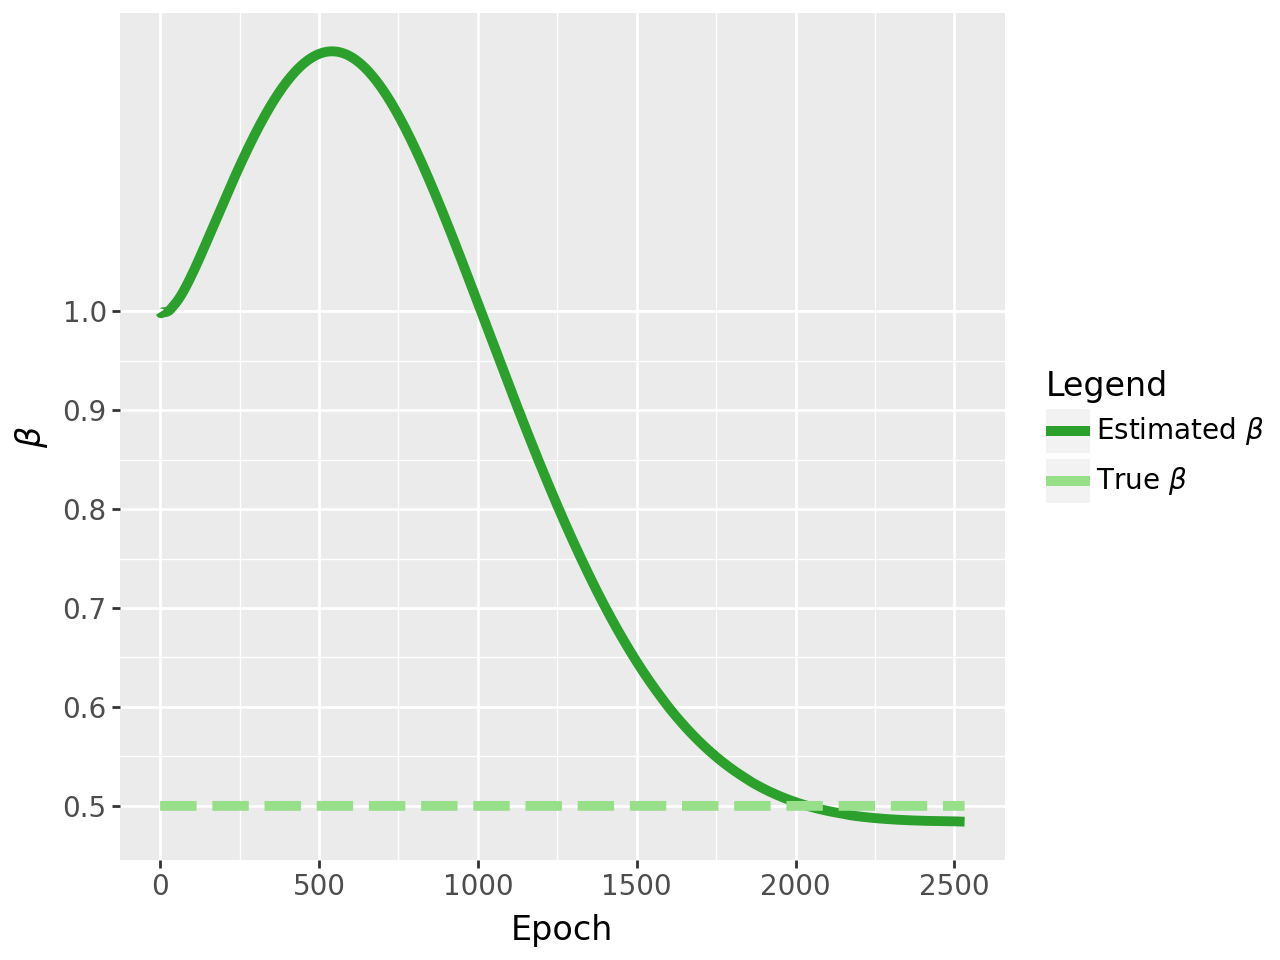

Saved plot as DI_IP_beta_plot.png


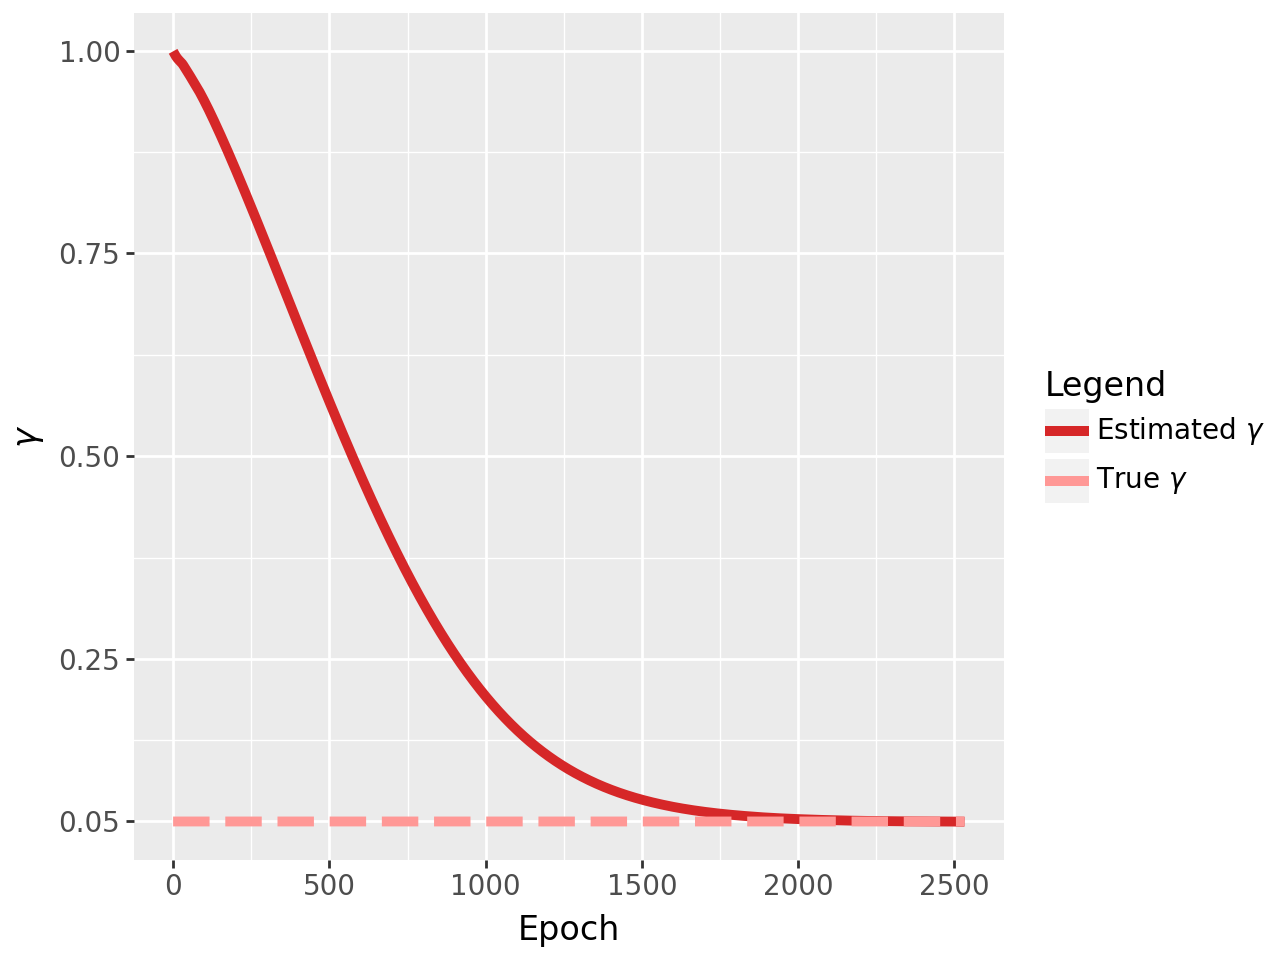

Saved plot as DI_IP_gamma_plot.png


In [4]:
import torch
import torch.optim as optim
from model_IP import SIRPINN
from data_utils_IP import load_and_prepare_sir_data
from training_IP import prepare_dataloader, train_with_physics_loss_sir
from plot_utils import plot_parameters_IP

def main():
    # Define true parameters
    true_params = {
        'beta': 0.5,
        'gamma': 0.05
    }
    # Define device and batch size
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size = 32

    t_train_set, t_test_set, data_S_train_set, data_I_train_set, data_R_train_set, data_S_test_set, data_I_test_set, data_R_test_set = load_and_prepare_sir_data()
    
    model = SIRPINN(input_dim=1, hidden_dims=[50, 50, 50], output_dim=3).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_loader = prepare_dataloader(t_train_set, data_S_train_set, data_I_train_set, data_R_train_set, batch_size=128, device=device)
    
    epochs = 15000
    patience = 50
    history, train_losses, parameter_estimates = train_with_physics_loss_sir(model, optimizer, epochs, patience, 
                                                                            *next(iter(train_loader)))

    # Plot results
    plot_parameters_IP(parameter_estimates, true_params, epochs)

if __name__ == "__main__":
    main()
